# Digital Humanities & FAccT Paper Analysis

This notebook examines whether Digital Humanities and FAccT-style papers are disproportionately affected by arxiv's policy on review/position papers. We identify these papers using keyword matching on abstracts.

In [1]:
import json
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Keyword Definitions

We define keyword lists to identify papers in two categories:
- **Digital Humanities (DH)**: computational analysis of cultural/literary/historical content
- **FAccT**: fairness, accountability, transparency, ethics in AI/ML

In [ ]:
# Digital Humanities keywords
DH_KEYWORDS = [
    # Core DH terms
    'digital humanities',
    'computational humanities',
    'cultural analytics',
    'distant reading',
    'close reading',
    
    # Literary/textual analysis
    'literary',
    'literature',
    'poetry',
    # 'novel',
    'fiction',
    'narrative',
    'storytelling',
    'authorship',
    'stylometry',
    'text reuse',
    
    # Historical/archival
    'historical',
    'history',
    'archive',
    'manuscript',
    'ancient',
    'medieval',
    'classical',
    'heritage',
    'digitization',
    
    # Cultural analysis
    'cultural',
    'culture',
    'art',
    'music',
    'film',
    'media studies',
]

# Core NLP keywords (for comparison baseline)
CORE_NLP_KEYWORDS = [
    # Tasks
    'named entity recognition',
    'part-of-speech',
    'pos tagging',
    'dependency parsing',
    'constituency parsing',
    'semantic parsing',
    'coreference',
    'word sense disambiguation',
    'relation extraction',
    'information extraction',
    'text classification',
    'sentiment analysis',
    'machine translation',
    'question answering',
    'reading comprehension',
    'summarization',
    'text generation',
    'dialogue',
    'conversational',
    
    # Models/methods
    'language model',
    'transformer',
    'attention mechanism',
    'bert',
    'gpt',
    'encoder-decoder',
    'seq2seq',
    'sequence labeling',
    'fine-tuning',
    'pre-training',
    'prompt',
    'in-context learning',
    
    # Representations
    'word embedding',
    'word2vec',
    'contextual embedding',
    'tokenization',
    'subword',
    'bpe',
    
    # Evaluation
    'bleu',
    'rouge',
    'f1 score',
    'perplexity',
]

# FAccT (Fairness, Accountability, Transparency) keywords
FACCT_KEYWORDS = [
    # Core FAccT terms
    'fairness',
    'accountability',
    'transparency',
    'explainability',
    'interpretability',
    
    # Bias and harm
    'bias',
    'biased',
    'discrimination',
    'discriminatory',
    'harm',
    'harmful',
    'toxicity',
    'toxic',
    'hate speech',
    'misinformation',
    'disinformation',
    
    # Ethics
    'ethics',
    'ethical',
    'moral',
    'responsible ai',
    'ai safety',
    'value alignment',
    
    # Social impact
    'social impact',
    'societal',
    'equity',
    'justice',
    'marginalized',
    'underrepresented',
    
    # Specific bias types
    'gender bias',
    'racial bias',
    'stereotype',
    'stereotypical',
    
    # Governance/policy
    'governance',
    'regulation',
    'audit',
    'auditing',
    'benchmark',  # in context of fairness benchmarks
    
    # Privacy
    'privacy',
    'surveillance',
    'consent',
]

In [3]:
def match_keywords(text, keywords):
    """Check if text contains any of the keywords (case-insensitive)."""
    if not text:
        return False
    text_lower = text.lower()
    return any(kw.lower() in text_lower for kw in keywords)

def count_keyword_matches(text, keywords):
    """Count how many keywords match in the text."""
    if not text:
        return 0
    text_lower = text.lower()
    return sum(1 for kw in keywords if kw.lower() in text_lower)

def get_matched_keywords(text, keywords):
    """Return list of matched keywords."""
    if not text:
        return []
    text_lower = text.lower()
    return [kw for kw in keywords if kw.lower() in text_lower]

In [4]:
# Load data
import ast
results_dir = Path('../data/results')

cs_categories = [
    'cs-AI', 'cs-CL', 'cs-CR', 'cs-CV', 'cs-CY',
    'cs-HC', 'cs-IR', 'cs-LG', 'cs-RO', 'cs-SE',
]

category_names = {
    'cs-AI': 'AI', 'cs-CL': 'Comp. Ling.', 'cs-CR': 'Crypto/Security',
    'cs-CV': 'Computer Vision', 'cs-CY': 'Computers & Society',
    'cs-HC': 'HCI', 'cs-IR': 'Info. Retrieval', 'cs-LG': 'Machine Learning',
    'cs-RO': 'Robotics', 'cs-SE': 'Software Eng.',
}

def load_category_data(category):
    all_items = []
    # Load post-LLM JSON data (2023+)
    json_filepath = results_dir / category / 'pangram_detection_results.json'
    if json_filepath.exists():
        with open(json_filepath) as f:
            data = json.load(f)
        for item in data:
            item['category'] = category
        all_items.extend(data)
    
    # Load pre-LLM CSV data (2020-2022)
    csv_filepath = results_dir / category / 'pre_pangram_detection_results.csv'
    if csv_filepath.exists():
        csv_df = pd.read_csv(csv_filepath)
        csv_df['pangram_prediction'] = csv_df['pangram_prediction'].apply(ast.literal_eval)
        csv_df['category'] = category
        all_items.extend(csv_df.to_dict('records'))
    
    return all_items

all_data = []
for cat in cs_categories:
    all_data.extend(load_category_data(cat))

df = pd.DataFrame(all_data)
print(f"Loaded {len(df)} papers")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")

Loaded 40507 papers
Year range: 2020 - 2025


In [5]:
# Extract fields
df['text'] = df['pangram_prediction'].apply(lambda x: x.get('text', ''))
df['ai_prediction'] = df['pangram_prediction'].apply(lambda x: x['prediction'])
df['ai_likelihood'] = df['pangram_prediction'].apply(lambda x: x['ai_likelihood'])

# Classify papers
df['is_dh'] = df['text'].apply(lambda x: match_keywords(x, DH_KEYWORDS))
df['is_facct'] = df['text'].apply(lambda x: match_keywords(x, FACCT_KEYWORDS))
df['is_core_nlp'] = df['text'].apply(lambda x: match_keywords(x, CORE_NLP_KEYWORDS))
df['dh_keyword_count'] = df['text'].apply(lambda x: count_keyword_matches(x, DH_KEYWORDS))
df['facct_keyword_count'] = df['text'].apply(lambda x: count_keyword_matches(x, FACCT_KEYWORDS))
df['core_nlp_keyword_count'] = df['text'].apply(lambda x: count_keyword_matches(x, CORE_NLP_KEYWORDS))

# Binary flags
df['is_review'] = df['paper_type'].isin(['review', 'other'])
df['is_ai_flagged'] = df['ai_prediction'].isin(['Likely AI', 'Highly Likely AI'])
df['category_name'] = df['category'].map(category_names)

# Combined category (prioritize DH/FAccT over Core NLP for papers that match multiple)
def get_paper_category(row):
    if row['is_dh'] and row['is_facct']:
        return 'DH + FAccT'
    elif row['is_dh']:
        return 'Digital Humanities'
    elif row['is_facct']:
        return 'FAccT'
    elif row['is_core_nlp']:
        return 'Core NLP'
    else:
        return 'Other CS'

df['research_area'] = df.apply(get_paper_category, axis=1)

print(f"\nPaper counts by research area:")
print(df['research_area'].value_counts())


Paper counts by research area:
research_area
Digital Humanities    15091
Other CS               8701
DH + FAccT             7834
FAccT                  5239
Core NLP               3642
Name: count, dtype: int64


## 1. Distribution of DH and FAccT Papers by Subcategory

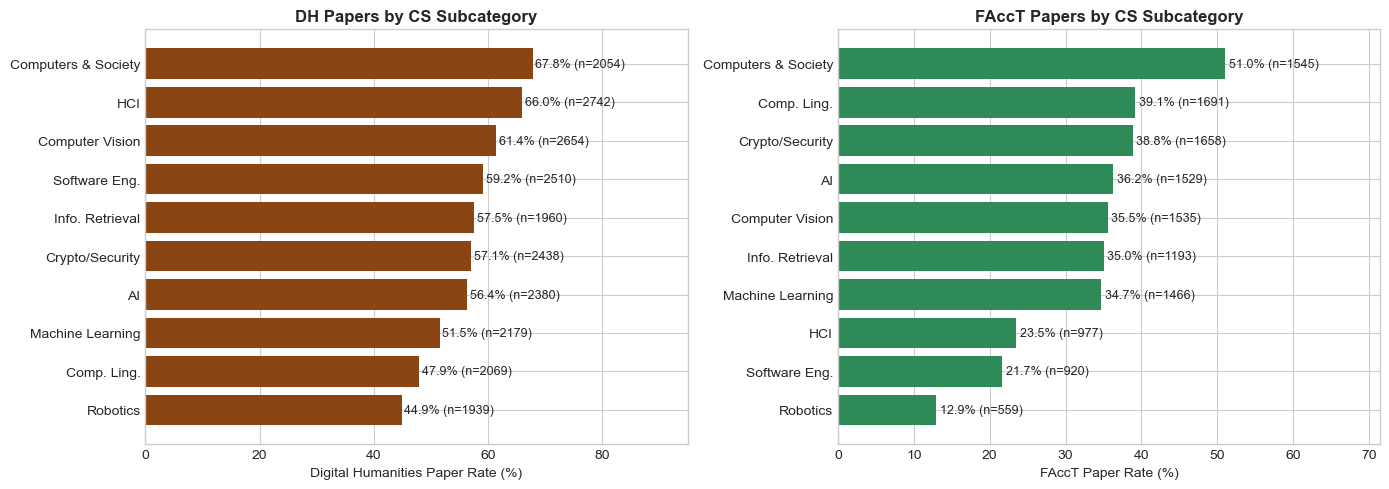

In [6]:
# Calculate rates by category
area_by_cat = df.groupby('category_name').agg(
    total=('arxiv_id', 'count'),
    dh_count=('is_dh', 'sum'),
    dh_rate=('is_dh', 'mean'),
    facct_count=('is_facct', 'sum'),
    facct_rate=('is_facct', 'mean'),
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DH papers
ax = axes[0]
data = area_by_cat.sort_values('dh_rate', ascending=True)
bars = ax.barh(data['category_name'], data['dh_rate'] * 100, color='#8B4513')
ax.set_xlabel('Digital Humanities Paper Rate (%)')
ax.set_title('DH Papers by CS Subcategory', fontweight='bold')
for bar, rate, count in zip(bars, data['dh_rate'], data['dh_count']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{rate*100:.1f}% (n={int(count)})', va='center', fontsize=9)
ax.set_xlim(0, max(data['dh_rate'] * 100) * 1.4)

# FAccT papers
ax = axes[1]
data = area_by_cat.sort_values('facct_rate', ascending=True)
bars = ax.barh(data['category_name'], data['facct_rate'] * 100, color='#2E8B57')
ax.set_xlabel('FAccT Paper Rate (%)')
ax.set_title('FAccT Papers by CS Subcategory', fontweight='bold')
for bar, rate, count in zip(bars, data['facct_rate'], data['facct_count']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{rate*100:.1f}% (n={int(count)})', va='center', fontsize=9)
ax.set_xlim(0, max(data['facct_rate'] * 100) * 1.4)

plt.tight_layout()
plt.savefig('../figures/dh_facct_by_category.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 2. Review Rates: DH/FAccT vs Other Papers

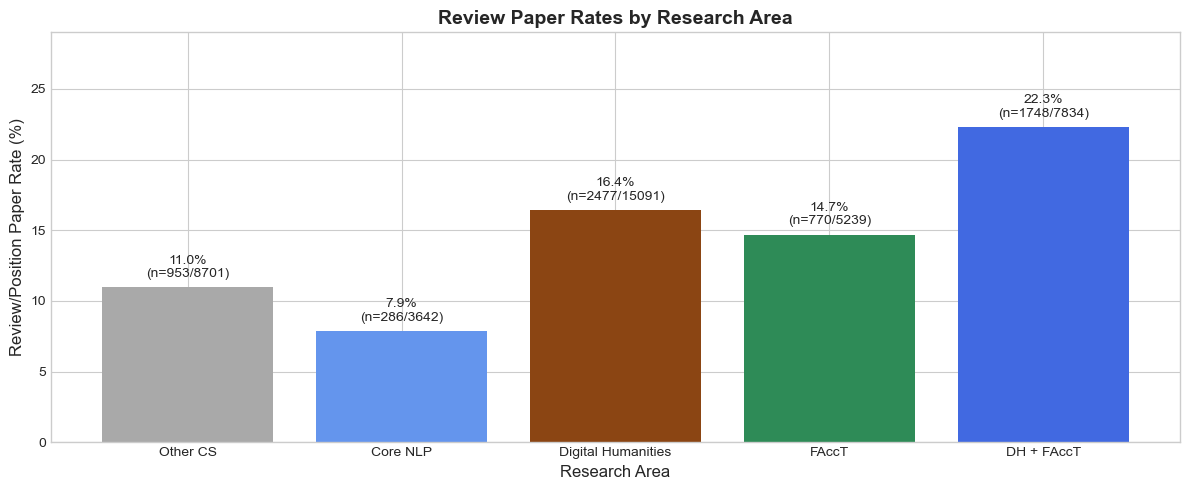

In [7]:
# Compare review rates by research area
review_by_area = df.groupby('research_area').agg(
    total=('arxiv_id', 'count'),
    review_count=('is_review', 'sum'),
    review_rate=('is_review', 'mean'),
).reset_index()

# Order for display
area_order = ['Other CS', 'Core NLP', 'Digital Humanities', 'FAccT', 'DH + FAccT']
review_by_area['research_area'] = pd.Categorical(review_by_area['research_area'], 
                                                  categories=area_order, ordered=True)
review_by_area = review_by_area.sort_values('research_area')

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#A9A9A9', '#6495ED', '#8B4513', '#2E8B57', '#4169E1']
bars = ax.bar(review_by_area['research_area'], review_by_area['review_rate'] * 100, 
              color=colors)

ax.set_ylabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_xlabel('Research Area', fontsize=12)
ax.set_title('Review Paper Rates by Research Area', fontsize=14, fontweight='bold')

# Add labels
for bar, rate, count, total in zip(bars, review_by_area['review_rate'], 
                                    review_by_area['review_count'], review_by_area['total']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{rate*100:.1f}%\n(n={int(count)}/{int(total)})', 
            ha='center', va='bottom', fontsize=10)

ax.set_ylim(0, max(review_by_area['review_rate'] * 100) * 1.3)
plt.tight_layout()
plt.savefig('../figures/review_rate_by_research_area.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 3. AI Detection Rates: DH/FAccT vs Other Papers

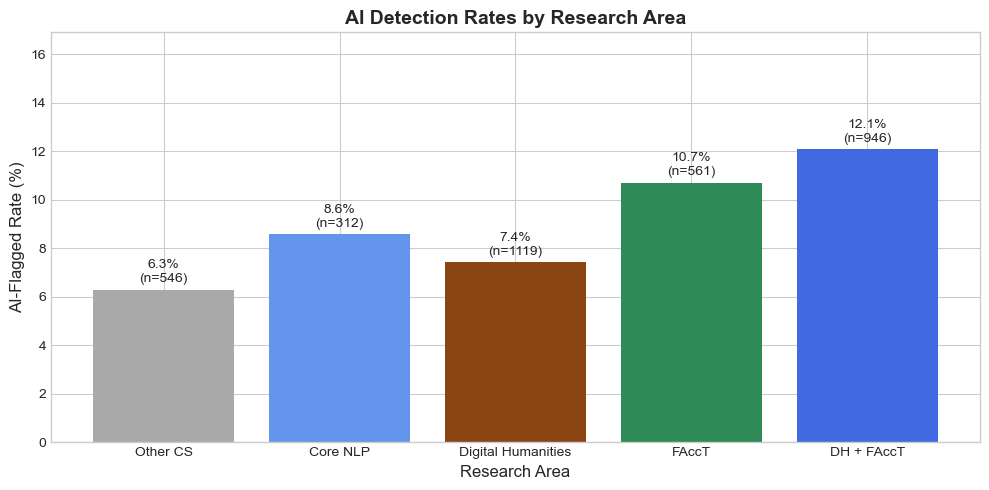

In [8]:
# Compare AI detection rates by research area
ai_by_area = df.groupby('research_area').agg(
    total=('arxiv_id', 'count'),
    ai_flagged=('is_ai_flagged', 'sum'),
    ai_rate=('is_ai_flagged', 'mean'),
    mean_likelihood=('ai_likelihood', 'mean'),
).reset_index()

ai_by_area['research_area'] = pd.Categorical(ai_by_area['research_area'], 
                                              categories=area_order, ordered=True)
ai_by_area = ai_by_area.sort_values('research_area')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(ai_by_area['research_area'], ai_by_area['ai_rate'] * 100, color=colors)

ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_xlabel('Research Area', fontsize=12)
ax.set_title('AI Detection Rates by Research Area', fontsize=14, fontweight='bold')

for bar, rate, count in zip(bars, ai_by_area['ai_rate'], ai_by_area['ai_flagged']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{rate*100:.1f}%\n(n={int(count)})', ha='center', va='bottom', fontsize=10)

ax.set_ylim(0, max(ai_by_area['ai_rate'] * 100) * 1.4)
plt.tight_layout()
plt.savefig('../figures/ai_rate_by_research_area.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 4. Combined Impact: Review Rate vs AI Rate by Research Area

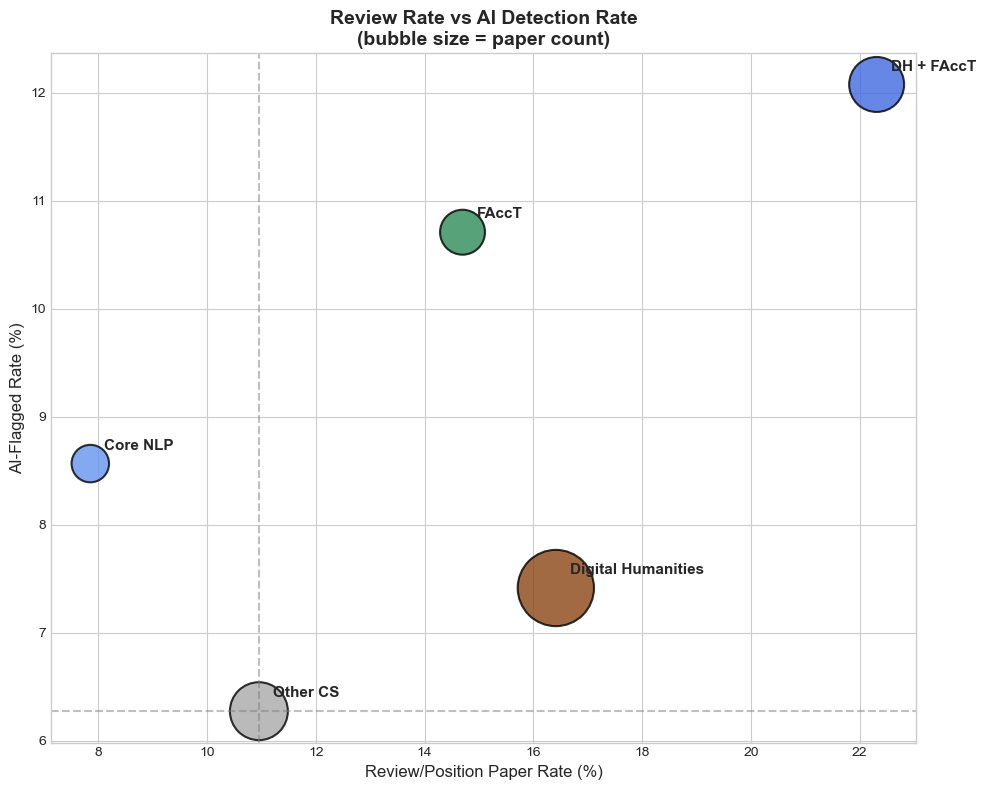

In [9]:
# Merge and create scatter
combined = review_by_area.merge(ai_by_area, on='research_area', suffixes=('_rev', '_ai'))

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(
    combined['review_rate'] * 100,
    combined['ai_rate'] * 100,
    s=combined['total_rev'] / 5,
    c=colors,
    alpha=0.8,
    edgecolors='black',
    linewidths=1.5
)

for idx, row in combined.iterrows():
    ax.annotate(
        row['research_area'],
        (row['review_rate'] * 100, row['ai_rate'] * 100),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=11,
        fontweight='bold'
    )

ax.set_xlabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_title('Review Rate vs AI Detection Rate\n(bubble size = paper count)', 
             fontsize=14, fontweight='bold')

# Reference lines at Other CS values
other_cs = combined[combined['research_area'] == 'Other CS'].iloc[0]
ax.axvline(other_cs['review_rate'] * 100, color='gray', linestyle='--', alpha=0.5, label='Other CS baseline')
ax.axhline(other_cs['ai_rate'] * 100, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/dh_facct_review_vs_ai.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 5. Detailed Breakdown: AI Detection by Paper Type within Research Areas

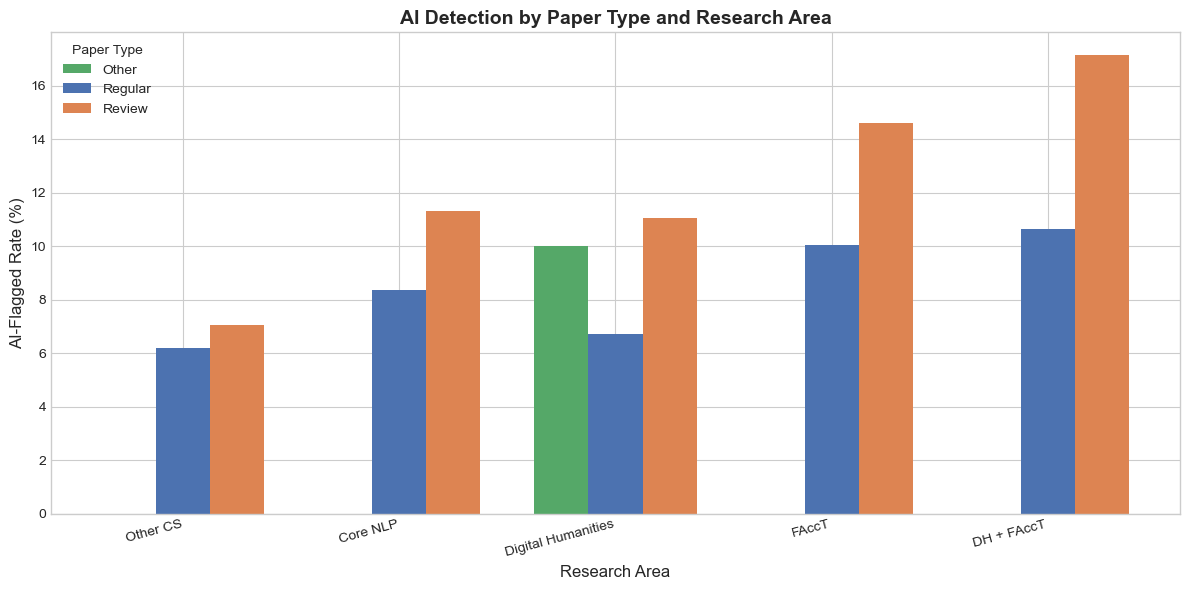

In [10]:
# Cross-tabulation: research area x paper type x AI detection
breakdown = df.groupby(['research_area', 'paper_type']).agg(
    count=('arxiv_id', 'count'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

# Pivot for grouped bar chart
pivot = breakdown.pivot(index='research_area', columns='paper_type', values='ai_rate').fillna(0)
pivot = pivot.reindex(area_order)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(pivot.index))
width = 0.25
type_colors = {'regular': '#4C72B0', 'review': '#DD8452', 'other': '#55A868'}

for i, col in enumerate(pivot.columns):
    ax.bar(x + i * width, pivot[col] * 100, width, 
           label=col.title(), color=type_colors.get(col, 'gray'))

ax.set_xlabel('Research Area', fontsize=12)
ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_title('AI Detection by Paper Type and Research Area', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(pivot.index, rotation=15, ha='right')
ax.legend(title='Paper Type')

plt.tight_layout()
plt.savefig('../figures/ai_by_type_and_area.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 6. Policy Impact Summary

In [11]:
# Summary statistics
summary = combined[['research_area', 'total_rev', 'review_rate', 'ai_rate']].copy()
summary['impact_score'] = summary['review_rate'] + summary['ai_rate']
summary.columns = ['Research Area', 'Total Papers', 'Review Rate', 'AI Rate', 'Impact Score']

# Format for display
summary_display = summary.copy()
summary_display['Review Rate'] = (summary_display['Review Rate'] * 100).round(2).astype(str) + '%'
summary_display['AI Rate'] = (summary_display['AI Rate'] * 100).round(2).astype(str) + '%'
summary_display['Impact Score'] = (summary_display['Impact Score'] * 100).round(2).astype(str) + '%'

print("=" * 80)
print("POLICY IMPACT SUMMARY")
print("=" * 80)
print(summary_display.to_string(index=False))
print("\n")

# Calculate relative impact
other_cs_review = summary[summary['Research Area'] == 'Other CS']['Review Rate'].values[0]
other_cs_ai = summary[summary['Research Area'] == 'Other CS']['AI Rate'].values[0]

print("Relative to 'Other CS' baseline:")
for _, row in summary.iterrows():
    if row['Research Area'] != 'Other CS':
        review_mult = row['Review Rate'] / other_cs_review if other_cs_review > 0 else float('inf')
        ai_mult = row['AI Rate'] / other_cs_ai if other_cs_ai > 0 else float('inf')
        print(f"  {row['Research Area']}: {review_mult:.1f}x review rate, {ai_mult:.1f}x AI rate")

POLICY IMPACT SUMMARY
     Research Area  Total Papers Review Rate AI Rate Impact Score
          Other CS          8701      10.95%   6.28%       17.23%
          Core NLP          3642       7.85%   8.57%       16.42%
Digital Humanities         15091      16.41%   7.42%       23.83%
             FAccT          5239       14.7%  10.71%       25.41%
        DH + FAccT          7834      22.31%  12.08%       34.39%


Relative to 'Other CS' baseline:
  Core NLP: 0.7x review rate, 1.4x AI rate
  Digital Humanities: 1.5x review rate, 1.2x AI rate
  FAccT: 1.3x review rate, 1.7x AI rate
  DH + FAccT: 2.0x review rate, 1.9x AI rate


## 7. Top Keywords in Flagged Papers

In [12]:
# Which keywords appear most in AI-flagged vs non-flagged papers?
from collections import Counter

def get_all_matches(df_subset, keywords):
    all_matches = []
    for text in df_subset['text']:
        all_matches.extend(get_matched_keywords(text, keywords))
    return Counter(all_matches)

# DH keywords in flagged vs not flagged
dh_papers = df[df['is_dh']]
flagged_dh = get_all_matches(dh_papers[dh_papers['is_ai_flagged']], DH_KEYWORDS)
not_flagged_dh = get_all_matches(dh_papers[~dh_papers['is_ai_flagged']], DH_KEYWORDS)

print("Top DH keywords in AI-FLAGGED papers:")
for kw, count in flagged_dh.most_common(10):
    print(f"  {kw}: {count}")

print("\nTop DH keywords in NOT flagged papers:")
for kw, count in not_flagged_dh.most_common(10):
    print(f"  {kw}: {count}")

Top DH keywords in AI-FLAGGED papers:
  art: 1788
  literature: 170
  cultural: 130
  historical: 92
  classical: 72
  narrative: 64
  culture: 59
  history: 41
  low-resource language: 17
  authorship: 15

Top DH keywords in NOT flagged papers:
  art: 18582
  literature: 1858
  historical: 806
  classical: 618
  history: 498
  cultural: 412
  culture: 333
  narrative: 308
  music: 159
  low-resource language: 106


In [13]:
# FAccT keywords analysis
facct_papers = df[df['is_facct']]
flagged_facct = get_all_matches(facct_papers[facct_papers['is_ai_flagged']], FACCT_KEYWORDS)
not_flagged_facct = get_all_matches(facct_papers[~facct_papers['is_ai_flagged']], FACCT_KEYWORDS)

print("Top FAccT keywords in AI-FLAGGED papers:")
for kw, count in flagged_facct.most_common(10):
    print(f"  {kw}: {count}")

print("\nTop FAccT keywords in NOT flagged papers:")
for kw, count in not_flagged_facct.most_common(10):
    print(f"  {kw}: {count}")

Top FAccT keywords in AI-FLAGGED papers:
  benchmark: 531
  privacy: 277
  ethical: 209
  bias: 195
  transparency: 166
  interpretability: 133
  governance: 116
  harm: 103
  fairness: 92
  audit: 77

Top FAccT keywords in NOT flagged papers:
  benchmark: 4909
  privacy: 1877
  bias: 1813
  harm: 949
  interpretability: 606
  transparency: 553
  ethical: 537
  fairness: 529
  biased: 522
  regulation: 417


## 8. Example Papers

In [14]:
# Show example DH/FAccT papers that are flagged as reviews AND AI-generated
double_flagged = df[(df['is_review']) & (df['is_ai_flagged']) & 
                    ((df['is_dh']) | (df['is_facct']))]

print(f"Papers flagged as BOTH review AND AI-generated in DH/FAccT areas: {len(double_flagged)}")
print("\nExamples:")
for _, row in double_flagged.head(5).iterrows():
    print(f"\n  arxiv_id: {row['arxiv_id']}")
    print(f"  Category: {row['category_name']}")
    print(f"  Research area: {row['research_area']}")
    print(f"  Paper type: {row['paper_type']}")
    print(f"  AI prediction: {row['ai_prediction']}")
    print(f"  Abstract preview: {row['text'][:200]}...")

Papers flagged as BOTH review AND AI-generated in DH/FAccT areas: 685

Examples:

  arxiv_id: 2304.10596
  Category: AI
  Research area: Digital Humanities
  Paper type: review
  AI prediction: Highly Likely AI
  Abstract preview: Enhancing Artificial intelligence Policies with Fusion and Forecasting:
  Insights from Indian Patents Using Network Analysis

  This paper presents a study of the interconnectivity and interdependenc...

  arxiv_id: 2304.14583
  Category: AI
  Research area: Digital Humanities
  Paper type: review
  AI prediction: Highly Likely AI
  Abstract preview: \'Epilexie: A digital therapeutic approach for treating intractable
  epilepsy via Amenable Neurostimulation

  Epilepsy is a neurological illness that is characterised by continuous spasms
of shaking...

  arxiv_id: 2306.03601
  Category: AI
  Research area: Digital Humanities
  Paper type: review
  AI prediction: Likely AI
  Abstract preview: The Creative Frontier of Generative AI: Managing the Novelty-Usefuln

## 9. Year-by-Year Analysis: Review Rates by Research Area Over Time

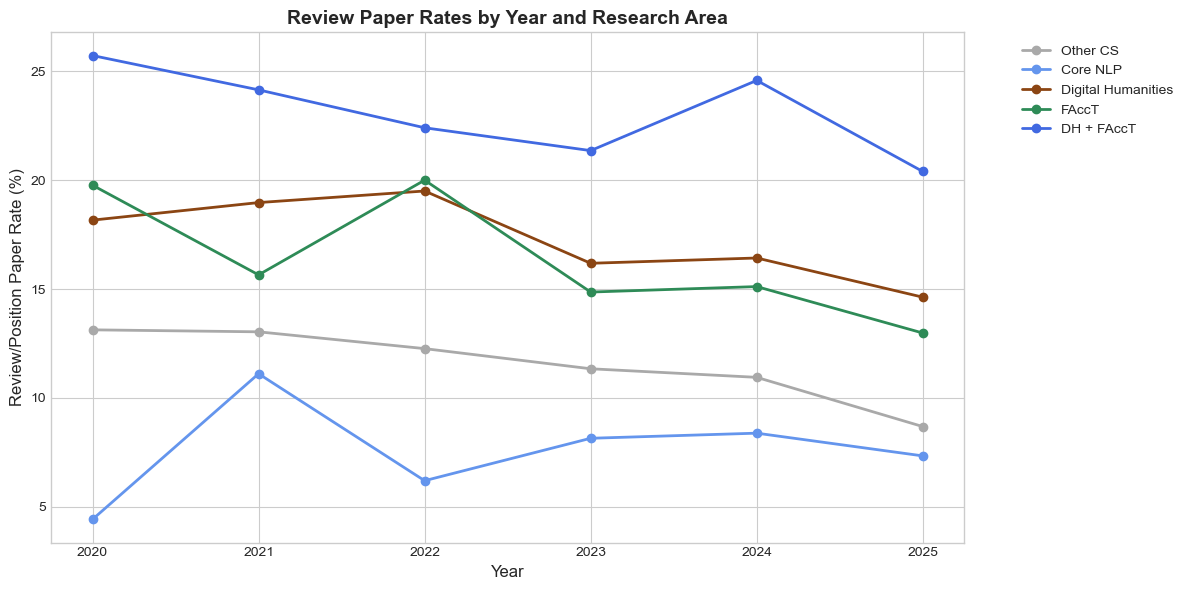

In [15]:
# Review rates by year and research area
review_by_year = df.groupby(['year', 'research_area']).agg(
    total_papers=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

area_colors = {'Other CS': '#A9A9A9', 'Core NLP': '#6495ED', 
               'Digital Humanities': '#8B4513', 'FAccT': '#2E8B57', 'DH + FAccT': '#4169E1'}

for area in area_order:
    if area in review_by_year['research_area'].values:
        data = review_by_year[review_by_year['research_area'] == area]
        ax.plot(data['year'], data['review_rate'] * 100, marker='o', 
                label=area, linewidth=2, color=area_colors.get(area, 'gray'))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_title('Review Paper Rates by Year and Research Area', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(review_by_year['year'].unique())

plt.tight_layout()
plt.savefig('../figures/dh_facct_review_rates_by_year.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 10. Year-by-Year Analysis: AI Detection Rates by Research Area Over Time

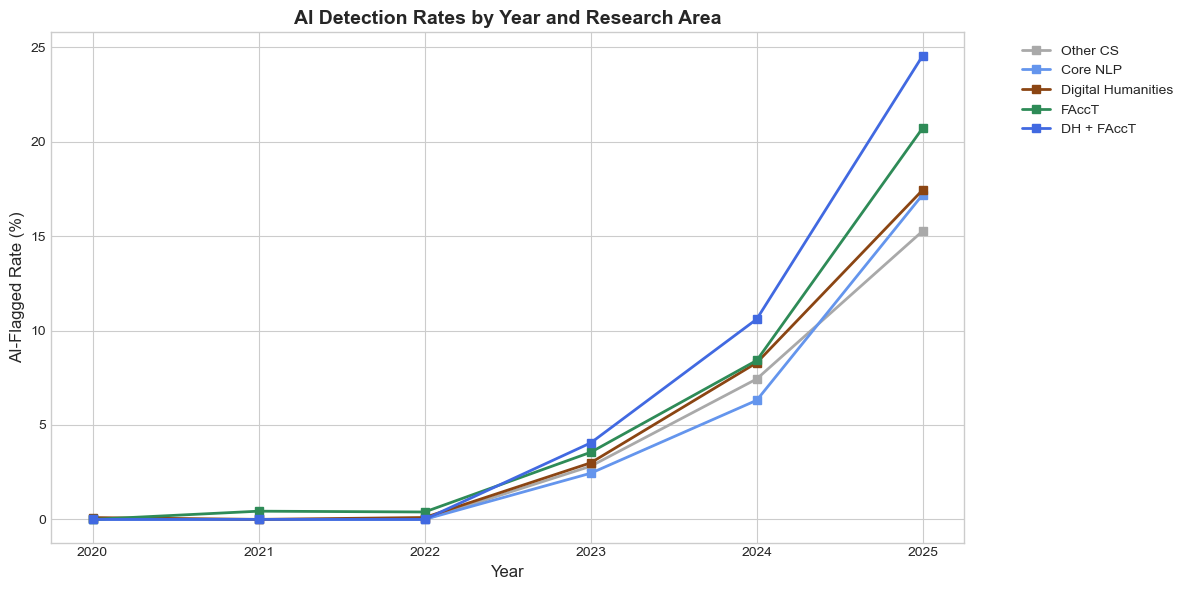

In [16]:
# AI detection rates by year and research area
ai_by_year = df.groupby(['year', 'research_area']).agg(
    total_papers=('arxiv_id', 'count'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

for area in area_order:
    if area in ai_by_year['research_area'].values:
        data = ai_by_year[ai_by_year['research_area'] == area]
        ax.plot(data['year'], data['ai_rate'] * 100, marker='s', 
                label=area, linewidth=2, color=area_colors.get(area, 'gray'))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_title('AI Detection Rates by Year and Research Area', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(ai_by_year['year'].unique())

plt.tight_layout()
plt.savefig('../figures/dh_facct_ai_rates_by_year.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 11. Year-by-Year Trends: DH/FAccT vs Other CS Over Time

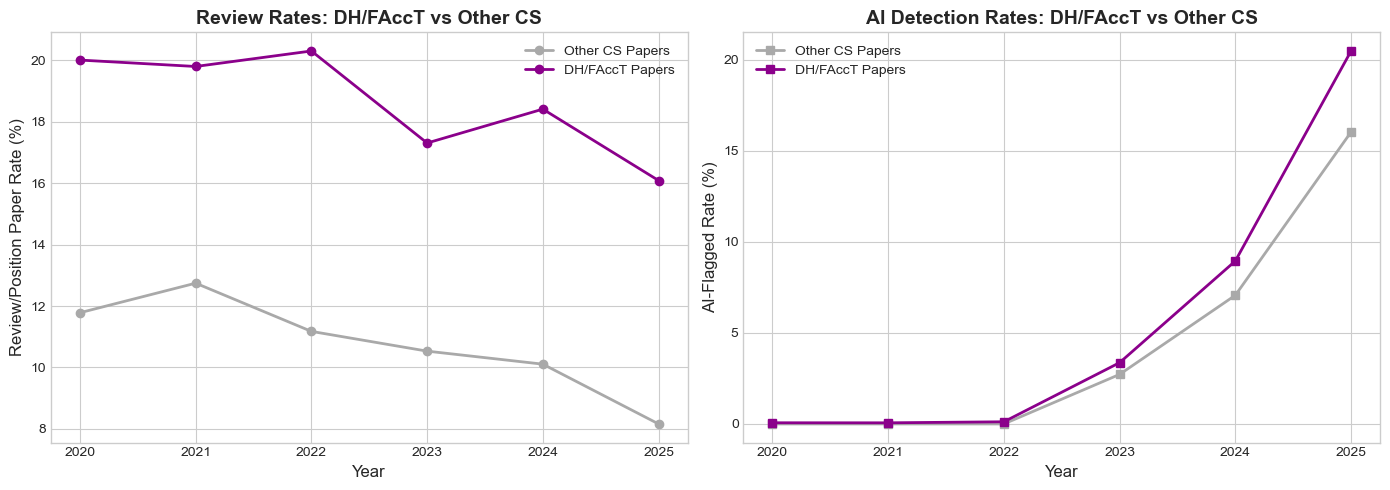

In [17]:
# Side-by-side comparison: DH/FAccT combined vs Other CS by year
df['is_dh_or_facct'] = df['is_dh'] | df['is_facct']

yearly_comparison = df.groupby(['year', 'is_dh_or_facct']).agg(
    total_papers=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

yearly_comparison['group'] = yearly_comparison['is_dh_or_facct'].map(
    {True: 'DH/FAccT Papers', False: 'Other CS Papers'})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Review rates
ax = axes[0]
for group in ['Other CS Papers', 'DH/FAccT Papers']:
    data = yearly_comparison[yearly_comparison['group'] == group]
    color = '#A9A9A9' if group == 'Other CS Papers' else '#8B008B'
    ax.plot(data['year'], data['review_rate'] * 100, marker='o', 
            label=group, linewidth=2, color=color)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Review/Position Paper Rate (%)', fontsize=12)
ax.set_title('Review Rates: DH/FAccT vs Other CS', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xticks(yearly_comparison['year'].unique())

# AI detection rates
ax = axes[1]
for group in ['Other CS Papers', 'DH/FAccT Papers']:
    data = yearly_comparison[yearly_comparison['group'] == group]
    color = '#A9A9A9' if group == 'Other CS Papers' else '#8B008B'
    ax.plot(data['year'], data['ai_rate'] * 100, marker='s', 
            label=group, linewidth=2, color=color)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('AI-Flagged Rate (%)', fontsize=12)
ax.set_title('AI Detection Rates: DH/FAccT vs Other CS', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xticks(yearly_comparison['year'].unique())

plt.tight_layout()
plt.savefig('../figures/dh_facct_vs_other_by_year.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 12. Year-by-Year Summary Table

In [18]:
# Summary table by year and research area
yearly_summary = df.groupby(['year', 'research_area']).agg(
    total_papers=('arxiv_id', 'count'),
    review_rate=('is_review', 'mean'),
    ai_rate=('is_ai_flagged', 'mean')
).reset_index()

yearly_summary['review_rate'] = (yearly_summary['review_rate'] * 100).round(2)
yearly_summary['ai_rate'] = (yearly_summary['ai_rate'] * 100).round(2)

print('=== Year-by-Year Summary by Research Area ===')
for year in sorted(yearly_summary['year'].unique()):
    print(f'\n{year}:')
    year_data = yearly_summary[yearly_summary['year'] == year]
    for _, row in year_data.iterrows():
        print(f"  {row['research_area']}: {row['total_papers']} papers, "
              f"{row['review_rate']}% review, {row['ai_rate']}% AI-flagged")

=== Year-by-Year Summary by Research Area ===

2020:
  Core NLP: 113 papers, 4.42% review, 0.0% AI-flagged
  DH + FAccT: 346 papers, 25.72% review, 0.0% AI-flagged
  Digital Humanities: 1046 papers, 18.16% review, 0.1% AI-flagged
  FAccT: 172 papers, 19.77% review, 0.0% AI-flagged
  Other CS: 617 papers, 13.13% review, 0.0% AI-flagged

2021:
  Core NLP: 117 papers, 11.11% review, 0.0% AI-flagged
  DH + FAccT: 410 papers, 24.15% review, 0.0% AI-flagged
  Digital Humanities: 991 papers, 18.97% review, 0.0% AI-flagged
  FAccT: 230 papers, 15.65% review, 0.43% AI-flagged
  Other CS: 652 papers, 13.04% review, 0.0% AI-flagged

2022:
  Core NLP: 129 papers, 6.2% review, 0.0% AI-flagged
  DH + FAccT: 424 papers, 22.41% review, 0.0% AI-flagged
  Digital Humanities: 1005 papers, 19.5% review, 0.1% AI-flagged
  FAccT: 255 papers, 20.0% review, 0.39% AI-flagged
  Other CS: 587 papers, 12.27% review, 0.0% AI-flagged

2023:
  Core NLP: 859 papers, 8.15% review, 2.44% AI-flagged
  DH + FAccT: 1901 p